# Decision Tree

### 1. Data Downlaoad and Preprocessing

#### Data set structure:

Monitored - particular website (950 url)

Unmonitored - except monitored site (10000 url)




In [1]:
import os
import pickle

FILE_IDS = {
    "mon_standard.pkl": "1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63",
    "unmon_standard10.pkl": "1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn",
}

try:
    gdown.download_folder
except:
    !pip install gdown

import gdown

def download_data_for_colab():
    for filename, file_id in FILE_IDS.items():
        filepath = f"/content/{filename}"
        if not os.path.exists(filepath):
            print(f"Downloading {filename} ...")
            !gdown --id $file_id -O $filepath --fuzzy
            print(f"{filename} download COMPLETE")
        else:
            print(f"{filename} already exists")

download_data_for_colab()

def load_and_preprocess_data(file_path, max_len, total_urls, is_monitored,
                             url_per_site=10, sample_size=None):

    with open(file_path, "rb") as f:
        data = pickle.load(f)

    X1_seq, X2_seq, labels = [], [], []

    indices = np.random.choice(total_urls, sample_size, replace=False) if sample_size else range(total_urls)
    data = [data[i] for i in indices]

    for i, entry in enumerate(data):
        if is_monitored:
            label = i // url_per_site
            samples = entry         # list of traces
        else:
            label = -1
            samples = [entry]       # unmon = 1 trace

        for seq in samples:
            time_seq = []
            size_seq = []

            for c in seq[:max_len]:
                direction = 1 if c > 0 else -1
                time_seq.append(abs(c))
                size_seq.append(direction * 512)

            X1_seq.append(time_seq)
            X2_seq.append(size_seq)
            if is_monitored:
                labels.append(label)

    return X1_seq, X2_seq, np.array(labels)


# plot funciton
def plot_curves(y_test, y_score, title_prefix):
    from sklearn.metrics import roc_curve, precision_recall_curve

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label='ROC')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.grid(True)
    plt.show()

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(y_test, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(rec, prec, label='PR Curve')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63
From (redirected): https://drive.google.com/uc?id=1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63&confirm=t&uuid=e76a07d9-9ebd-4dee-9119-a37706b9e894
To: /content/mon_standard.pkl
100% 717M/717M [00:05<00:00, 126MB/s]
mon_standard.pkl download COMPLETE
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn
From (redirected): https://drive.google.com/uc?id=1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn&confirm=t&uuid=655227d8-4a01-469b-8b13-ca

In [2]:
import numpy as np

MON_FILE = "/content/mon_standard.pkl"
UNMON_FILE = "/content/unmon_standard10.pkl"

X1_mon, X2_mon, y_mon = load_and_preprocess_data(MON_FILE, max_len=1500, total_urls=950, is_monitored=True,url_per_site=10, sample_size=190)

X1_un, X2_un, _ = load_and_preprocess_data(UNMON_FILE, max_len=2000, total_urls=10000, is_monitored=False,sample_size=500)

### 2. Feature Extraction


#### feature set:
same with SVM, RF, ...

In [3]:
import pandas as pd

def compute_bursts(size_seq):
    if len(size_seq) == 0:
        return []
    bursts = []
    cur = np.sign(size_seq[0])
    cur_sum = size_seq[0]

    for s in size_seq[1:]:
        sg = np.sign(s)
        if sg == cur:
            cur_sum += s
        else:
            bursts.append(cur_sum)
            cur = sg
            cur_sum = s
    bursts.append(cur_sum)
    return bursts

def compute_zero_crossings(arr):
    if len(arr) == 0:
        return 0
    sgn = np.sign(arr)
    for i in range(len(sgn)):
        if sgn[i] == 0:
            sgn[i] = sgn[i-1] if i > 0 else 0
    return np.sum(np.diff(sgn) != 0)

def extract_features_one_trace(times, sizes, initial_k=30):
    times = np.array(times, dtype=float)
    sizes = np.array(sizes, dtype=float)
    n_packets = len(sizes)

    if n_packets == 0 or len(times) == 0:
        return {k:0 for k in [
            "n_total","n_out","n_in","ratio_out_in","frac_out",
            "mean_inter_time","std_inter_time","min_inter_time","max_inter_time",
            "n_bursts","mean_burst_interval",
            "initial_n_out","initial_n_in",
            "initial_mean_inter_time","initial_std_inter_time",
            "cum_final","cum_abs_sum","cum_max_abs","cum_zero_crossings"
        ]}

    # counts
    n_out = np.sum(sizes > 0)
    n_in  = np.sum(sizes < 0)
    ratio = n_out / max(n_in, 1)
    frac_out = n_out / n_packets

    if len(times) >= 2:
        inter = np.diff(times)
        mean_inter = inter.mean()
        std_inter  = inter.std()
        min_inter  = inter.min()
        max_inter  = inter.max()
    else:
        mean_inter = std_inter = min_inter = max_inter = 0.0

    # Bursts
    bursts = compute_bursts(sizes)
    n_bursts = len(bursts)
    mean_burst_interval = 0.0
    if n_bursts >= 2:
        burst_starts = [0]
        cur = np.sign(sizes[0])
        for i in range(1, n_packets):
            if np.sign(sizes[i]) != cur:
                burst_starts.append(i)
                cur = np.sign(sizes[i])
        bt = np.array(times)[burst_starts]
        if len(bt) >= 2:
            mean_burst_interval = np.mean(np.diff(bt))

    k = min(initial_k, n_packets)
    init_sizes = sizes[:k]
    init_times = times[:k]

    init_out = np.sum(init_sizes > 0)
    init_in  = np.sum(init_sizes < 0)

    if k >= 2:
        inter0 = np.diff(init_times)
        init_m = inter0.mean()
        init_s = inter0.std()
    else:
        init_m = init_s = 0.0

    cum = np.cumsum(sizes)

    return {
        "n_total": int(n_packets),
        "n_out": int(n_out),
        "n_in":  int(n_in),
        "ratio_out_in": float(ratio),
        "frac_out": float(frac_out),

        "mean_inter_time": float(mean_inter),
        "std_inter_time": float(std_inter),
        "min_inter_time": float(min_inter),
        "max_inter_time": float(max_inter),

        "n_bursts": int(n_bursts),
        "mean_burst_interval": float(mean_burst_interval),

        "initial_n_out": int(init_out),
        "initial_n_in": int(init_in),
        "initial_mean_inter_time": float(init_m),
        "initial_std_inter_time": float(init_s),

        "cum_final": float(cum[-1]),
        "cum_abs_sum": float(np.abs(cum).sum()),
        "cum_max_abs": float(np.abs(cum).max()),
        "cum_zero_crossings": int(compute_zero_crossings(cum)),
    }


def build_feature_dataframe(X1, X2):
    return pd.DataFrame([extract_features_one_trace(t, s) for t, s in zip(X1, X2)])


#  feature sets
df_mon = build_feature_dataframe(X1_mon, X2_mon)
df_mon["label"] = y_mon

df_un  = build_feature_dataframe(X1_un, X2_un)
df_un["label"] = 0



### 3. CLOSED-WORLD (95-class)

this experiment aimed to which site emerge traffic among 95 monitored site

#### [Model Structure - Variable]
creterion = "entropy" => information gain
max_depth = 70 => consider the complex traffic structure
class_weight = "balanced"
random_state = 42


#### [data split]
monitored data: total 190 url
20 trace per url => 3800 samples
Train:Test = 80:20

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,  f1_score
)


df_mon_cw = df_mon.copy()


df_mon_cw["label"] = np.array(list(range(len(df_mon_cw)))) // 20

X = df_mon_cw.drop("label", axis=1)
y = df_mon_cw["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# CLOSED-WORLD (95-class)


print("CLOSED-WORLD (95-class)")

dt_cw = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=70,
    class_weight="balanced",
    random_state=42
)

dt_cw.fit(X_train, y_train)
pred = dt_cw.predict(X_test)

acc = accuracy_score(y_test, pred)
macro_f1 = f1_score(y_test, pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")



CLOSED-WORLD (95-class)
Accuracy: 0.3908
Macro-F1: 0.3792


### 4. OPEN-WORLD (Binary) monitored(1) vs unmonitored(0)

this OPEN WORLD experiment aimed to check whether traffic is monitored site or not

#### [Model Structure - Variable]
monitored: label=1
unmonitored: label=0
max_depth=50, entropy based
class_weight="balanced"

Open-world(Binary) Model Evaluation
Score - Precision: 0.9835
Score - Recall: 0.9912
Score - ROC-AUC: 0.9323
Score - Balanced Accuracy: 0.9323


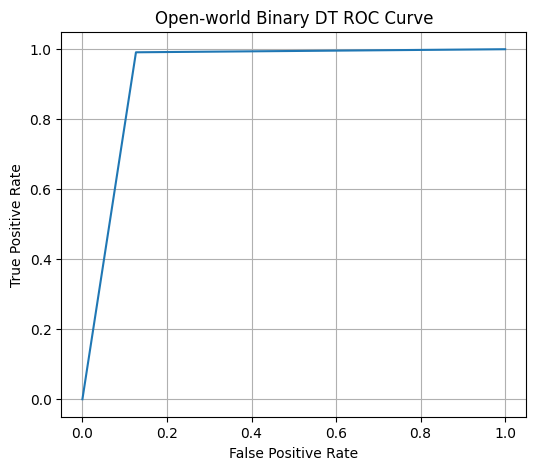

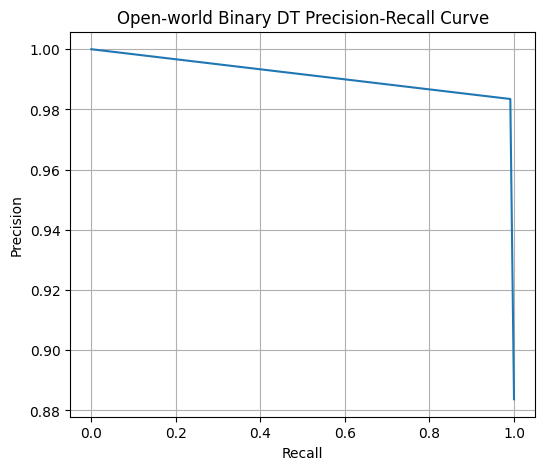

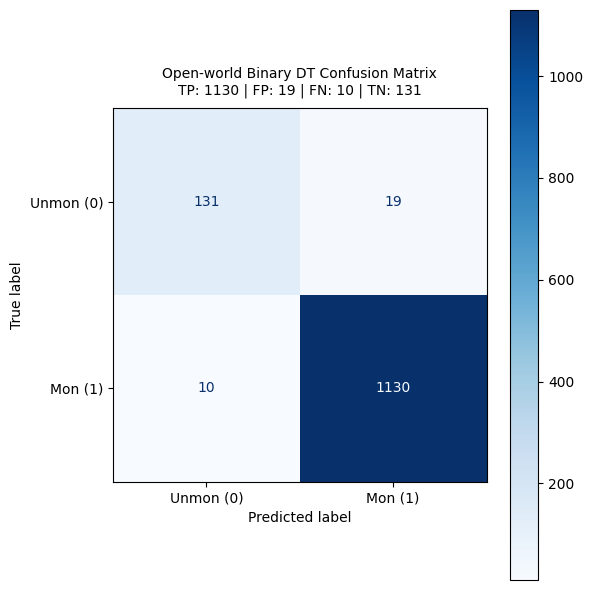

In [5]:
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score,
    balanced_accuracy_score, confusion_matrix , ConfusionMatrixDisplay
)


# binary에서는 모두 1로 바꿈
df_mon_bin = df_mon_cw.copy()
df_mon_bin["label"] = 1

# unmon already exists
df_un_bin = df_un.copy()
df_un_bin["label"] = 0

df_un_bin = df_un_bin[df_mon_bin.columns]

df_open_bin = pd.concat([df_mon_bin, df_un_bin], ignore_index=True)

Xb = df_open_bin.drop("label", axis=1)
yb = df_open_bin["label"]

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.3, stratify=yb, random_state=42
)


# OPEN-WORLD (Binary DT)
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score,
    balanced_accuracy_score, confusion_matrix
)

print("Open-world(Binary) Model Evaluation")


dt_bin = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=50,
    class_weight="balanced",
    random_state=42
)

dt_bin.fit(Xb_train, yb_train)

y_pred = dt_bin.predict(Xb_test)
y_score = dt_bin.predict_proba(Xb_test)[:, 1]

precision = precision_score(yb_test, y_pred)
recall = recall_score(yb_test, y_pred)
roc_auc = roc_auc_score(yb_test, y_score)
balanced_acc = balanced_accuracy_score(yb_test, y_pred)

print(f"Score - Precision: {precision:.4f}")
print(f"Score - Recall: {recall:.4f}")
print(f"Score - ROC-AUC: {roc_auc:.4f}")
print(f"Score - Balanced Accuracy: {balanced_acc:.4f}")

# Plot ROC & PR curves
plot_curves(yb_test, y_score, "Open-world Binary DT")

# Confusion Matrix
cm = confusion_matrix(yb_test, y_pred)
TN, FP, FN, TP = cm.ravel()
title_string = (
    f"Open-world Binary DT Confusion Matrix\n"
    f"TP: {TP} | FP: {FP} | FN: {FN} | TN: {TN}"
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unmon (0)', 'Mon (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title(title_string, fontsize=10, pad=10)
plt.tight_layout()
plt.show()


### 5.  OPEN-WORLD (Multi-class: 0~94 + -1)


monitored class: 95

unmonitored class: -1

=> total 96 class

 OPEN-WORLD MULTI-CLASS
Accuracy: 0.4326
Macro-F1: 0.3710


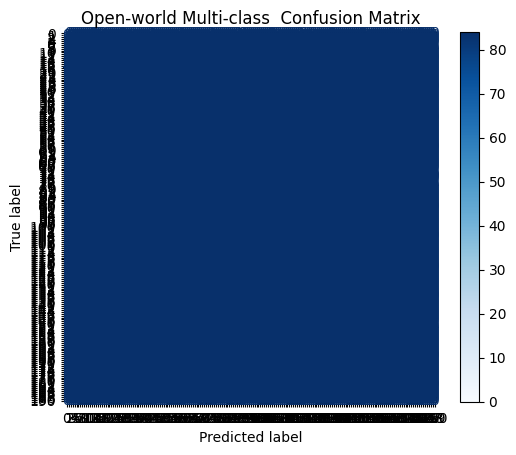

In [6]:

df_un_multi = df_un.copy()
df_un_multi["label"] = -1

df_mon_multi = df_mon_cw.copy()

df_open_multi = pd.concat([df_mon_multi, df_un_multi], ignore_index=True)

Xm = df_open_multi.drop("label", axis=1)
ym = df_open_multi["label"]

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, random_state=42, stratify=ym)

dt_multi = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=50,
    class_weight="balanced",
    random_state=42
)

dt_multi.fit(Xm_train, ym_train)
pred_m = dt_multi.predict(Xm_test)

print(" OPEN-WORLD MULTI-CLASS")
print(f"Accuracy: {accuracy_score(ym_test, pred_m):.4f}")
print(f"Macro-F1: {f1_score(ym_test, pred_m, average='macro'):.4f}")

cm_multi = confusion_matrix(ym_test, pred_m)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi)
disp.plot(cmap=plt.cm.Blues)
plt.title("Open-world Multi-class  Confusion Matrix")
plt.show()


# Result Explanation

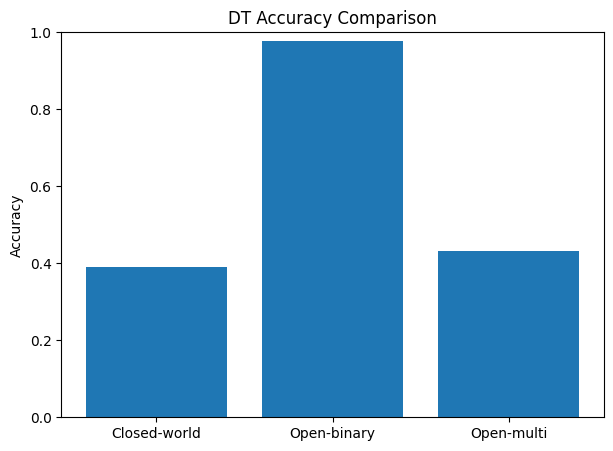

Closed-world Accuracy: 0.3908
Open-binary Accuracy: 0.9775
Open-multi Accuracy: 0.4326


In [7]:
import matplotlib.pyplot as plt

acc_scores = [
    accuracy_score(y_test, pred),
    accuracy_score(yb_test, y_pred),
    accuracy_score(ym_test, pred_m)
]

labels = ["Closed-world", "Open-binary", "Open-multi"]

plt.figure(figsize=(7,5))
plt.bar(labels, acc_scores)
plt.ylabel("Accuracy")
plt.title("DT Accuracy Comparison")
plt.ylim(0,1)
plt.show()

print(f"Closed-world Accuracy: {acc_scores[0]:.4f}")
print(f"Open-binary Accuracy: {acc_scores[1]:.4f}")
print(f"Open-multi Accuracy: {acc_scores[2]:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 7 18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 7 18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 7 18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

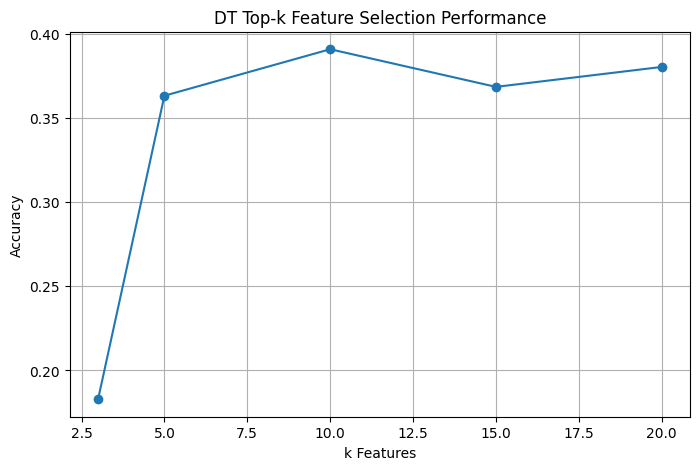

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

k_list = [3, 5, 10, 15, 20]
acc_k = []

X_base = df_mon_cw.drop("label", axis=1).values
y_base = df_mon_cw["label"].values

for k in k_list:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X_base, y_base)

    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_new, y_base, test_size=0.2, random_state=42)

    dt = DecisionTreeClassifier(criterion="entropy", max_depth=70, class_weight="balanced", random_state=42)
    dt.fit(X_train_k, y_train_k)
    pred_k = dt.predict(X_test_k)
    acc_k.append(accuracy_score(y_test_k, pred_k))

plt.figure(figsize=(8,5))
plt.plot(k_list, acc_k, marker='o')
plt.title("DT Top-k Feature Selection Performance")

plt.xlabel("k Features")
plt.ylabel("Accuracy")

plt.grid()

plt.show()


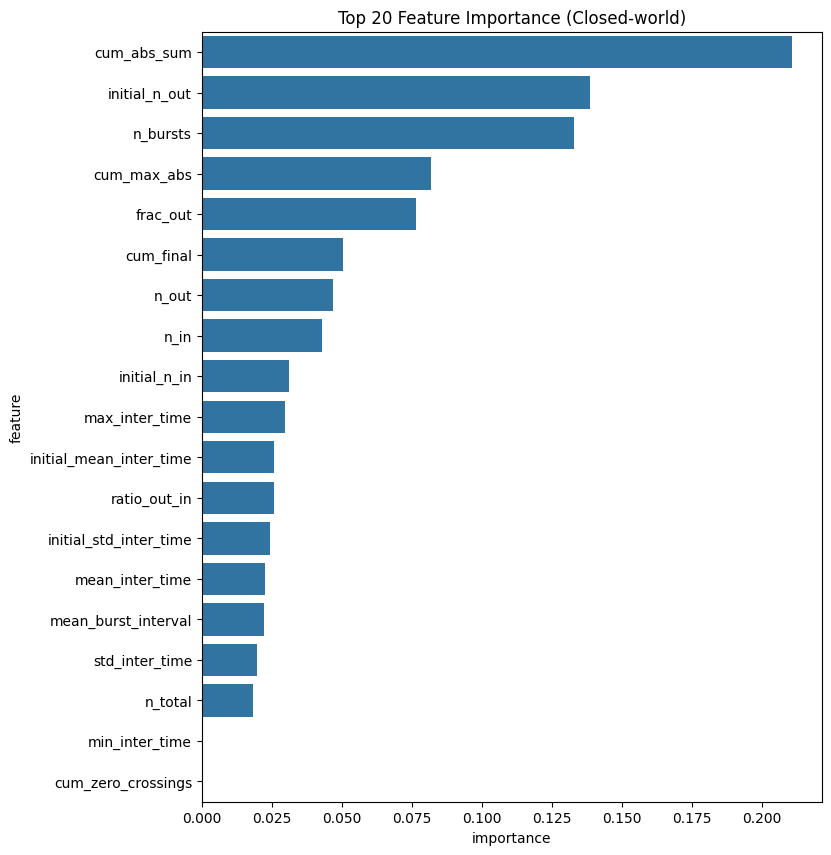

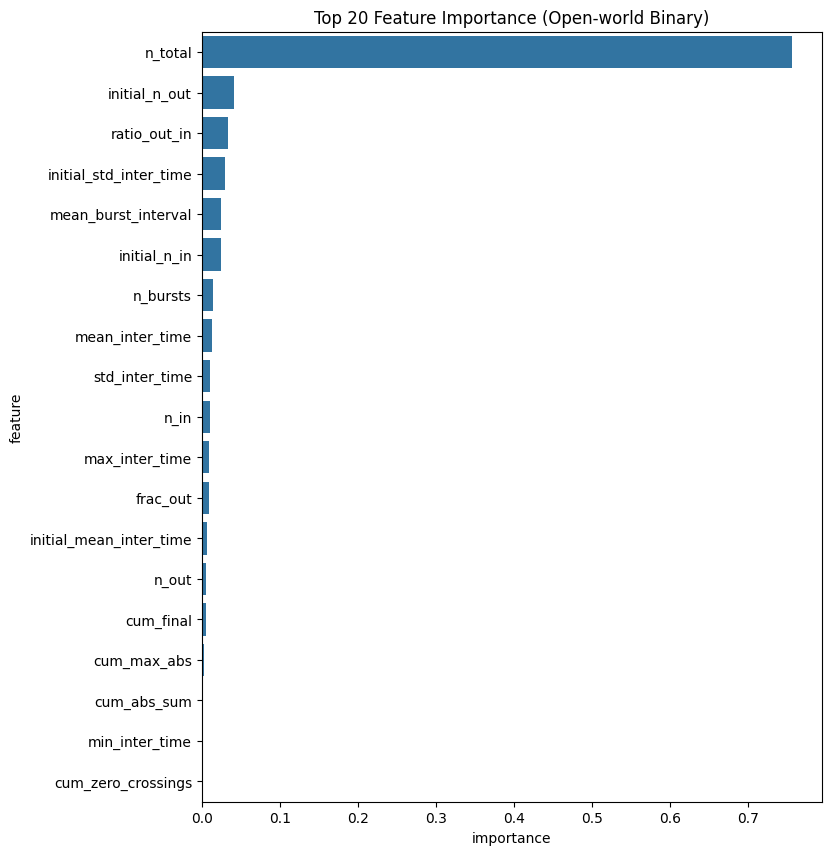

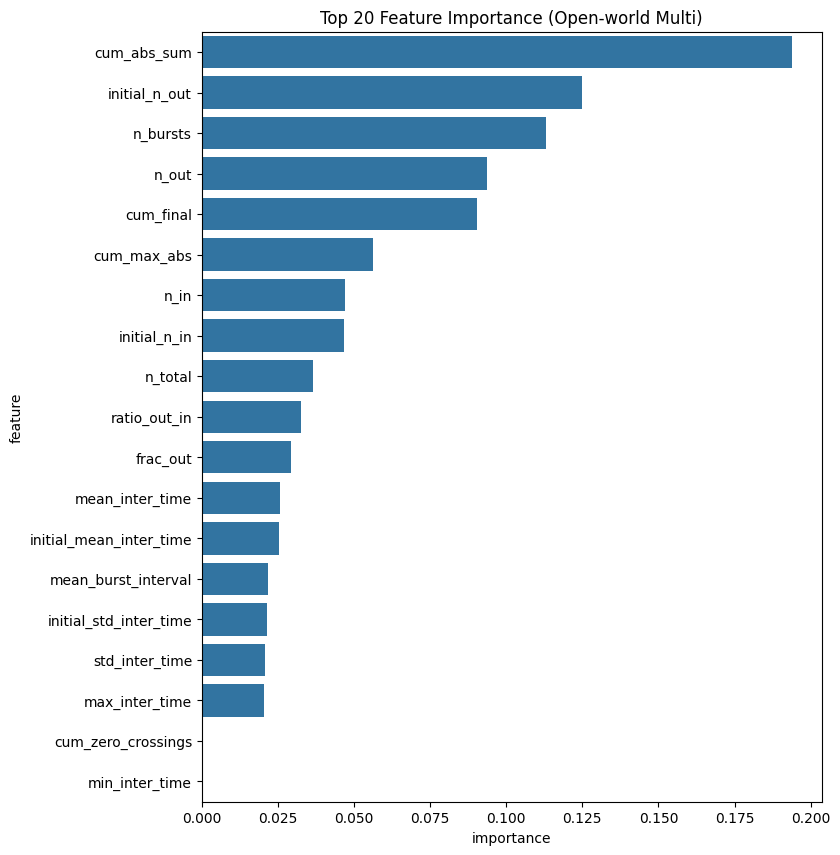

In [10]:
fi = dt_cw.feature_importances_
fi_df = pd.DataFrame({"feature": X.columns, "importance": fi}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importance (Closed-world)")
plt.show()



fi = dt_bin.feature_importances_
cols = Xb.columns

fi_df = pd.DataFrame({"feature": cols, "importance": fi})
fi_df = fi_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importance (Open-world Binary)")
plt.show()


fi_m = dt_multi.feature_importances_
fi_mdf = pd.DataFrame({"feature": Xm.columns, "importance": fi_m}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=fi_mdf.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importance (Open-world Multi)")
plt.show()
